In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

/Users/Sylvia/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [39]:
# Random seed
np.random.seed(123)

# Generate Data
disaster_data = pd.DataFrame({
    "year": np.arange(1600, 2017),
    "disasters": np.concatenate([
        np.random.poisson(4.1, 180),
        np.random.poisson(8.3, 150),
        np.random.poisson(3.2, 87)
    ])
})

# introduce random NaN's
missing = np.random.randint(0, disaster_data.shape[0], 5)
disaster_data.loc[missing, "disasters"] = np.nan

# plot the data
toyplot.scatterplot(
    disaster_data.year,
    disaster_data.disasters, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="N disasters",
);


1600 1700 1800 1900 2000 year 0 5 10 15 N disasters

In [40]:
with pm.Model() as disaster_model:
    
    # Special part: in total 2 switches involved
    # sample switchpoint 1 and 2 from within the timescale
    switchpoint_1 = pm.DiscreteUniform(
        'switchpoint 1',
        lower=disaster_data.year.min(), 
        upper=disaster_data.year.max(), 
        testval=1800)
    switchpoint_2 = pm.DiscreteUniform(
        'switchpoint 2',
        lower=switchpoint_1, 
        upper=disaster_data.year.max(), 
        testval=1900)

    # Priors for rates from pre- and post-switch 1 and 2
    early_rate = pm.Exponential('early_rate', 1.)
    middle_rate = pm.Exponential('middle_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years
    # Using 2 switch, one within the other
    rate = pm.math.switch(switchpoint_2 >= disaster_data.year, 
                          pm.math.switch(switchpoint_1 >= disaster_data.year, early_rate, middle_rate),
                          late_rate)
    
    disasters = pm.Poisson('disasters', rate, observed=disaster_data.disasters)

In [42]:
with disaster_model:
    trace = pm.sample(50000)

/Users/Sylvia/miniconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint 2]
>>Metropolis: [switchpoint 1]
>NUTS: [late_rate_log__, middle_rate_log__, early_rate_log__]
 99%|█████████▉| 50205/50500 [02:04<00:00, 403.65it/s]/Users/Sylvia/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|█████████▉| 50490/50500 [02:05<00:00, 403.84it/s]/Users/Sylvia/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 50500/50500 [02:05<00:00, 403.82it/s]
Tuning was enabled throughout t

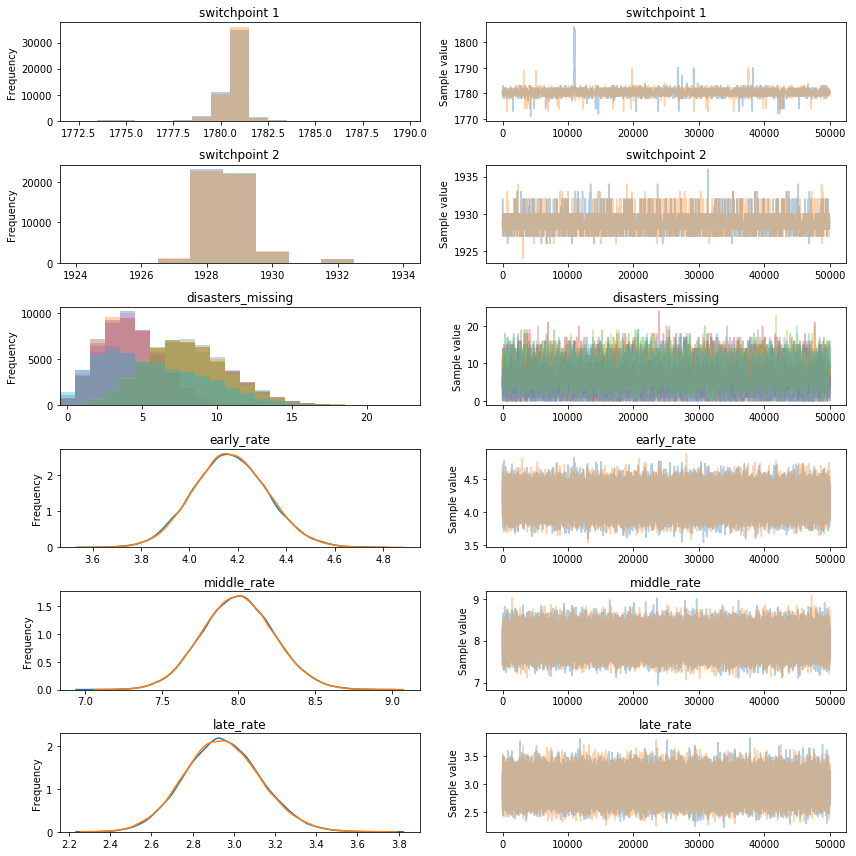

In [44]:
pm.traceplot(trace);

In [43]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint 1,1780.726520,1.210722,0.030436,1779.000000,1781.000000,992.0,1.000372
switchpoint 2,1928.616040,0.815558,0.013023,1928.000000,1930.000000,3660.0,1.000097
disasters_missing__0,4.204560,2.054384,0.024402,1.000000,8.000000,6675.0,1.000059
disasters_missing__1,4.188480,2.072466,0.029237,1.000000,8.000000,5697.0,0.999994
disasters_missing__2,8.024970,2.823835,0.047734,3.000000,13.000000,3804.0,1.000127
disasters_missing__3,7.927600,2.877210,0.050012,2.000000,13.000000,3360.0,1.001078
disasters_missing__4,5.560640,3.448734,0.074099,0.000000,12.000000,2044.0,0.999990
early_rate,4.168125,0.152758,0.000651,3.872822,4.470069,100000.0,1.000012
middle_rate,7.993101,0.234621,0.000886,7.541307,8.459873,100000.0,0.999997
late_rate,2.944035,0.183770,0.000494,2.596350,3.316110,100000.0,0.999991


### How is the model?
The model in general predicted the parameters well. The first switch at year 1780 is within 95% HPD value, and the second switch at year 1930 is also within 95% HPD value. And the rate values are all within 95% HPD values. I think the MCMC sampler is long enough.